In [70]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
import onnxmltools
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from scipy.special import expit 
from sklearn.model_selection import GridSearchCV
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from xgboost import XGBClassifier
from onnxruntime import InferenceSession

path = '/Users/maxchiu/Desktop/DSC106/project3/cases.csv'
df = pd.read_csv(path)
df




,caseid,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,...,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
0,1,5955,0,11542,-552,10848.0,1668,10368,-236220,627780,...,0,120,0.0,100,70,0,10,0,0,0
1,2,2487,0,15741,-1039,14921.0,1721,14621,-221160,1506840,...,0,150,0.0,0,100,0,20,0,0,0
2,3,2861,0,4394,-590,4210.0,1090,3010,-218640,40560,...,0,0,0.0,0,50,0,0,0,0,0
3,4,1903,0,20990,-778,20222.0,2522,17822,-201120,576480,...,0,80,0.0,100,100,0,50,0,0,0
4,5,4416,0,21531,-1009,22391.0,2591,20291,-67560,3734040,...,0,0,0.0,0,160,0,10,900,0,2100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6383,6384,5583,0,15248,-260,15640.0,2140,14140,-215340,648660,...,0,150,0.0,0,90,0,20,0,0,0
6384,6385,2278,0,20643,-544,20996.0,2396,19496,-225600,1675200,...,0,100,0.0,0,100,0,25,30,0,300
6385,6386,4045,0,19451,-667,19133.0,3533,18233,-200460,836340,...,0,70,0.0,0,130,0,10,0,0,0
6386,6387,5230,0,12025,-550,12830.0,1730,11030,-227760,377040,...,0,120,0.0,0,50,0,0,0,0,0


In [50]:
#prediction set
pred_sets = df[['age','height','weight','preop_hb','preop_plt','sex', 'optype','position','approach','ane_type','emop','death_inhosp']]
pred_sets

,age,height,weight,preop_hb,preop_plt,sex,optype,position,approach,ane_type,emop,death_inhosp
0,77.0,160.2,67.50,14.1,189.0,M,Colorectal,Lithotomy,Open,General,0,0
1,54.0,167.3,54.80,10.2,251.0,M,Stomach,Supine,Open,General,0,0
2,62.0,169.1,69.70,14.2,373.0,M,Biliary/Pancreas,Reverse Trendelenburg,Videoscopic,General,0,0
3,74.0,160.6,53.00,14.4,275.0,M,Stomach,Reverse Trendelenburg,Videoscopic,General,0,0
4,66.0,171.0,59.70,10.1,67.0,M,Vascular,Prone,Open,General,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6383,64.0,161.5,63.00,14.5,279.0,M,Stomach,Supine,Open,General,0,0
6384,69.0,159.3,62.30,15.2,239.0,M,Colorectal,Lithotomy,Videoscopic,General,0,0
6385,61.0,151.7,43.25,12.6,276.0,F,Stomach,Supine,Videoscopic,General,0,0
6386,24.0,155.7,55.50,12.5,214.0,F,Biliary/Pancreas,Supine,Robotic,General,0,0


In [72]:
# Load dataset (assuming df is already loaded)
# df = pd.read_csv('your_file.csv') # Uncomment if reading from CSV

# Define feature types
numeric_features = ['age', 'height', 'weight', 'preop_hb', 'preop_plt']
categorical_features = ['sex', 'optype', 'position', 'approach', 'ane_type', 'emop']
target_variable = 'death_inhosp'

# Split features and target
X = df[numeric_features + categorical_features]
y = df[target_variable]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle NaN values
    ('scaler', StandardScaler())  # Scale numeric features
])

categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical
])

# Column Transformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Model: XGBregressor
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42))
])


# Train the model
model.fit(X, y)

# Extract trained XGBoost model from pipeline
trained_xgb_model = model.named_steps['regressor']

# Save trained model as JSON
trained_xgb_model.save_model("xgboost_model.json")
print("✅ XGBoost model saved as JSON!")


# Define ONNX conversion input shape
initial_types = [('float_input', FloatTensorType([None, X.shape[1]]))]


# Convert the trained model to ONNX format
onnx_model = onnxmltools.convert_xgboost(trained_xgb_model, name="XGBoost ONNX Model", 
                                         initial_types = initial_types)

# Save the ONNX model
with open("xgboost_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("✅ Model converted to ONNX format!")


# # Cross-validation setup
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # Define scoring metrics
# mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
# r2_scorer = make_scorer(r2_score)

# # Perform cross-validation
# mse_scores = cross_val_score(model, X, y, cv=cv, scoring=mse_scorer)
# r2_scores = cross_val_score(model, X, y, cv=cv, scoring=r2_scorer)

# # Display results
# print(f'Cross-validated MSE scores: {-mse_scores}')  # Convert back to positive values
# print(f'Mean MSE: {-np.mean(mse_scores):.4f}')
# print(f'Cross-validated R² scores: {r2_scores}')
# print(f'Mean R² Score: {np.mean(r2_scores):.4f}')

✅ XGBoost model saved as JSON!
✅ Model converted to ONNX format!


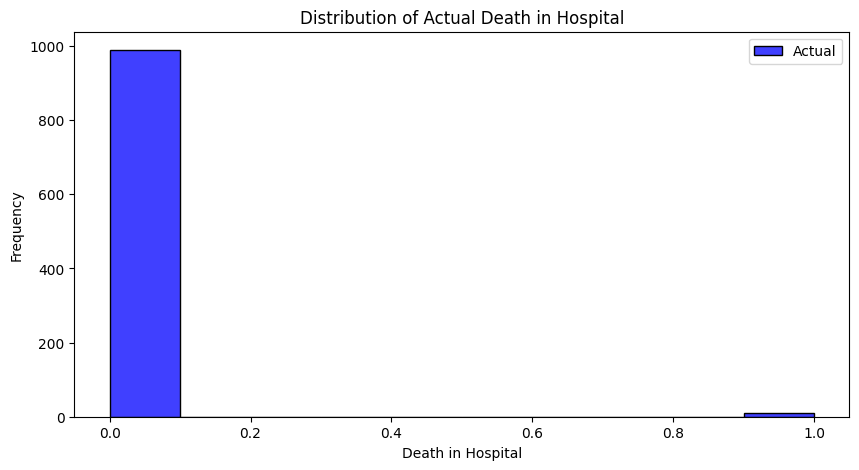

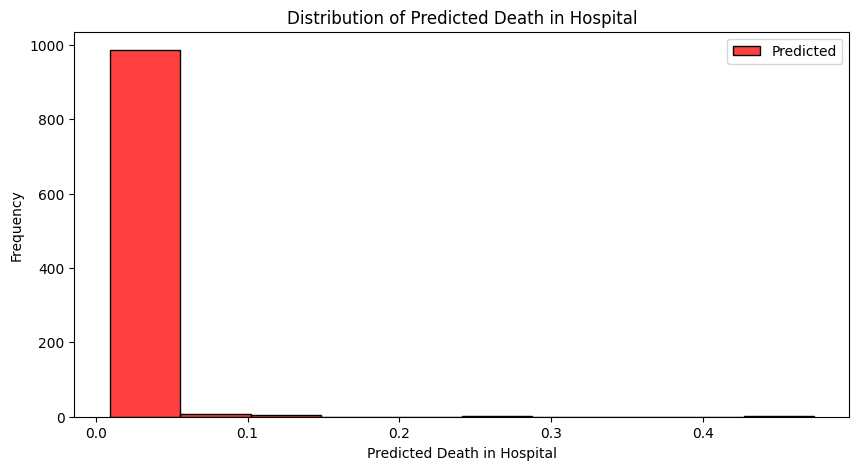

In [65]:


# Step 1: Select 1000 random rows
subset_df = df.sample(n=1000, random_state=42)

# Step 2: Plot histogram of actual 'death_inhosp'
plt.figure(figsize=(10, 5))
sns.histplot(subset_df['death_inhosp'], bins=10,  color='blue', label='Actual')
plt.xlabel('Death in Hospital')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Death in Hospital')
plt.legend()
plt.show()

# Step 3: Prepare the subset for prediction (drop target variable)
X_subset = subset_df.drop(columns=['death_inhosp'])

model.fit(X,y)

# Step 4: Predict using the trained model
predicted_death_inhosp = model.predict(X_subset)
predicted_death_inhosp = model.predict_proba(X_subset)[:, 1]

# Step 5: Plot histogram of predicted 'death_inhosp'
plt.figure(figsize=(10, 5))
sns.histplot(predicted_death_inhosp, bins=10, color='red', label='Predicted')
plt.xlabel('Predicted Death in Hospital')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Death in Hospital')
plt.legend()
plt.show()



In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss

# Define feature types
numeric_features = ['age', 'height', 'weight', 'preop_hb', 'preop_plt']
categorical_features = ['sex', 'optype', 'position', 'approach', 'ane_type', 'emop']
target_variable = 'death_inhosp'

# Split dataset into features (X) and target (y)
X = df[numeric_features + categorical_features]
y = df[target_variable]

# Preprocessing for numeric features
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle NaN values
    ('scaler', StandardScaler())  # Scale numeric features
])

# Preprocessing for categorical features
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical features
])

# Column Transformer (Combining Numeric & Categorical Pipelines)
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Model: RandomForestClassifier
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42, max_depth=6))
])

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Get predicted probabilities for log loss calculation
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Compute log loss
loss = log_loss(y_test, y_pred_proba)

# Print results
print(f"✅ Model trained with RandomForestClassifier")
print(f"📉 Log Loss: {loss:.4f}")

✅ Model trained with RandomForestClassifier
📉 Log Loss: 0.0553


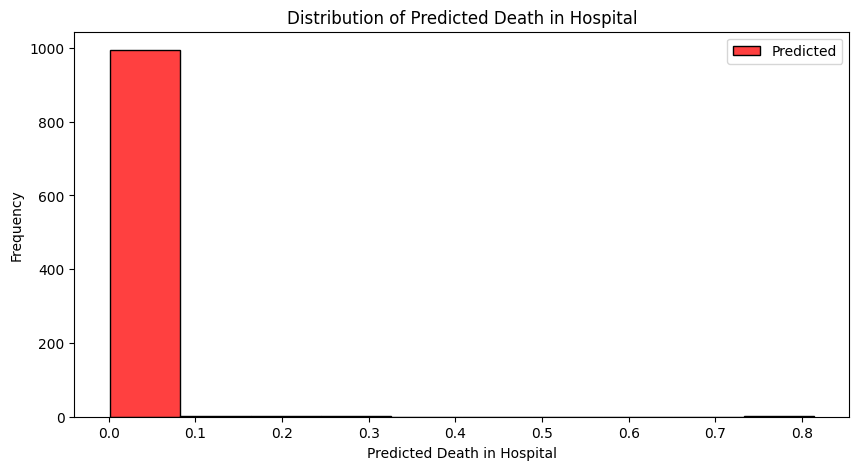

In [76]:
subset_df = df.sample(n=1000, random_state=42)
X_subset = subset_df.drop(columns=['death_inhosp'])
predicted_death_inhosp = model.predict_proba(X_subset)[:, 1]

# Step 5: Plot histogram of predicted 'death_inhosp'
plt.figure(figsize=(10, 5))
sns.histplot(predicted_death_inhosp, bins=10, color='red', label='Predicted')
plt.xlabel('Predicted Death in Hospital')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Death in Hospital')
plt.legend()
plt.show()

In [77]:
from sklearn.neighbors import KNeighborsRegressor
# Define feature types
numeric_features = ['age', 'height', 'weight', 'preop_hb', 'preop_plt']
categorical_features = ['sex', 'optype', 'position', 'approach', 'ane_type', 'emop']
target_variable = 'death_inhosp'

# Split dataset into features (X) and target (y)
X = df[numeric_features + categorical_features]
y = df[target_variable]

# Preprocessing for numeric features
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle NaN values
    ('scaler', StandardScaler())  # Scale numeric features
])

# Preprocessing for categorical features
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical features
])

# Column Transformer (Combining Numeric & Categorical Pipelines)
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Model: KNN Regressor
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=10, weights='distance'))
])

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict values
y_pred = model.predict(X_test)

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"✅ KNN Regressor trained!")
print(f"📉 Mean Squared Error (MSE): {mse:.4f}")
print(f"📊 R² Score: {r2:.4f}")

✅ KNN Regressor trained!
📉 Mean Squared Error (MSE): 0.0116
📊 R² Score: -0.0669


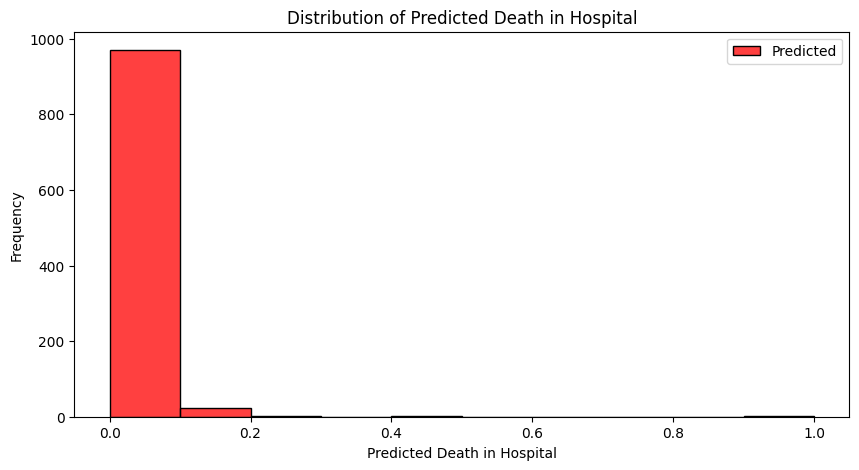

In [78]:
subset_df = df.sample(n=1000, random_state=42)
X_subset = subset_df.drop(columns=['death_inhosp'])
predicted_death_inhosp = model.predict(X_subset)

# Step 5: Plot histogram of predicted 'death_inhosp'
plt.figure(figsize=(10, 5))
sns.histplot(predicted_death_inhosp, bins=10, color='red', label='Predicted')
plt.xlabel('Predicted Death in Hospital')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Death in Hospital')
plt.legend()
plt.show()

In [79]:
# Define hyperparameter grid
param_grid = {
    'regressor__n_neighbors': [3, 5, 10, 20],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model using grid search
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("✅ Best Parameters:", grid_search.best_params_)
print("📉 Best MSE:", -grid_search.best_score_)

✅ Best Parameters: {'regressor__metric': 'manhattan', 'regressor__n_neighbors': 20, 'regressor__weights': 'distance'}
📉 Best MSE: 0.007287369906951988


In [80]:
# Define feature types
numeric_features = ['age', 'height', 'weight', 'preop_hb', 'preop_plt']
categorical_features = ['sex', 'optype', 'position', 'approach', 'ane_type', 'emop']
target_variable = 'death_inhosp'

# Split dataset into features (X) and target (y)
X = df[numeric_features + categorical_features]
y = df[target_variable]

# Preprocessing for numeric features
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle NaN values
    ('scaler', StandardScaler())  # Scale numeric features
])

# Preprocessing for categorical features
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical features
])

# Column Transformer (Combining Numeric & Categorical Pipelines)
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Model: KNN Regressor
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=20, weights='distance', metric = 'manhattan'))
])

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict values
y_pred = model.predict(X_test)

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"✅ KNN Regressor trained!")
print(f"📉 Mean Squared Error (MSE): {mse:.4f}")
print(f"📊 R² Score: {r2:.4f}")

✅ KNN Regressor trained!
📉 Mean Squared Error (MSE): 0.0110
📊 R² Score: -0.0138


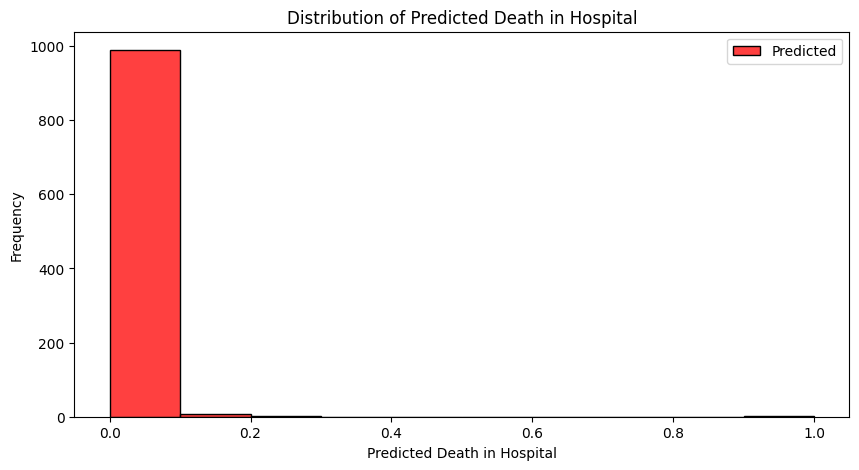

In [81]:
subset_df = df.sample(n=1000, random_state=42)
X_subset = subset_df.drop(columns=['death_inhosp'])
predicted_death_inhosp = model.predict(X_subset)

# Step 5: Plot histogram of predicted 'death_inhosp'
plt.figure(figsize=(10, 5))
sns.histplot(predicted_death_inhosp, bins=10, color='red', label='Predicted')
plt.xlabel('Predicted Death in Hospital')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Death in Hospital')
plt.legend()
plt.show()

In [86]:
unique_values_dict = {col: df[col].unique().tolist() for col in categorical_features}

# Display the result
for col, values in unique_values_dict.items():
    print(f"{col}: {values}")

sex: ['M', 'F']
optype: ['Colorectal', 'Stomach', 'Biliary/Pancreas', 'Vascular', 'Major resection', 'Breast', 'Minor resection', 'Transplantation', 'Hepatic', 'Thyroid', 'Others']
position: ['Lithotomy', 'Supine', 'Reverse Trendelenburg', 'Prone', 'Left lateral decubitus', 'Right lateral decubitus', nan, 'Trendelenburg', 'Sitting', 'Left kidney', 'Right kidney']
approach: ['Open', 'Videoscopic', 'Robotic']
ane_type: ['General', 'Spinal', 'Sedationalgesia']
emop: [0, 1]
